## Predict a global signal with the pretrained emulator

In [1]:
from VeryAccurateEmulator import emulator

In [2]:
pretrained_model = emulator.VeryAccurateEmulator()  # the pretrained emulator

2022-01-25 21:07:07.263512: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-01-25 21:07:07.263627: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-01-25 21:07:07.264354: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [3]:
# you can also load your own pretrained models saved to h5 Files like this:

# from tensorflow.keras.models import load_model
# my_emulator = load_model(<filepath>)
# my_vae = load_model(<filepath>)
# my_model = emulator.VeryAccurateEmulator(emulator=my_emulator)

In [4]:
# access the input parameters and their order
print(pretrained_model.par_labels)

['fstar', 'Vc', 'fx', 'tau', 'alpha', 'nu_min', 'Rmfp']


2022-01-25 21:07:07.333473: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-01-25 21:07:07.352721: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2995200000 Hz


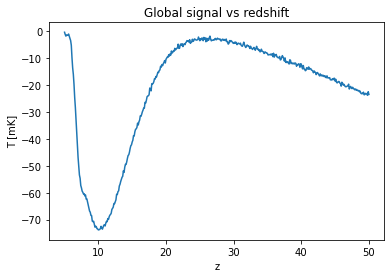

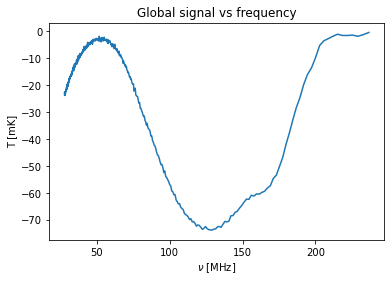

In [5]:
params = [0.0003, 4.2, 0, 0.055, 1.0, 0.1, 10]  # in the order given in the above cell

# alternatively, params can be a (N, 7)-numpy array, where N is the number of different cases you want to emulate at once.
# In that case, the output is a (N, 451)-numpy array. 
# For example, if you have a csv file with 500 cases organized in a 500x7-table, just do 
# params = np.loadtxt(<filepath>)

global_signal = pretrained_model.predict(params)  # emulate the global signal

import matplotlib.pyplot as plt
redshifts = pretrained_model.z_sampling  # an array of length 451 with redshifts 5-50:0.1
plt.figure()
plt.plot(redshifts, global_signal)
plt.title('Global signal vs redshift')
plt.xlabel('z')
plt.ylabel('T [mK]')
plt.show()

frequencies = pretrained_model.nu_sampling  # an array of length 451 with equivalent frequencies
plt.figure()
plt.plot(frequencies, global_signal)
plt.title('Global signal vs frequency')
plt.xlabel(r'$\nu$ [MHz]')
plt.ylabel('T [mK]')
plt.show()

In [6]:
import numpy as np
err = pretrained_model.compute_rms_error() # compute the relative error, with no input arguments, this computes the error on
# the same test set as used in the paper

# compute the absolute error in the frequency range 50-100 MHz, must set relative to False
abs_err = pretrained_model.compute_rms_error(relative=False, flow=50, fhigh=100)
print('Mean relative rms error:', np.mean(err))
print('Mean rms error in mK for frequencies between 50-100 MHz:', np.mean(abs_err))

# since we used no input arguments, we are testing the pretrained model on the test set in the paper. Thus, the results
# should match those given in Table 1 of the paper.

Mean relative rms error: 0.0034342161
Mean rms error in mK for frequencies between 50-100 MHz: 0.49636072


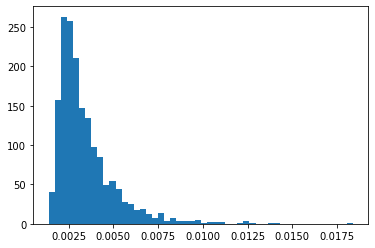

In [7]:
# Histogram of errors, should look like Figure 2 of the paper
plt.hist(err, bins=50)
plt.show()

## Training a new model

In [8]:
custom_model = emulator.VeryAccurateEmulator() # instantiate the 21cmVAE class

In [9]:
custom_model.get_hyperparameters() # the default hyperparameters

Hyperparameters are set to:
Direct emulator hidden dimensions: [288, 352, 288, 224]
Activation function: relu


In [10]:
# change the hyperparameters: the available hyperparameters are called "direct_em_dims", and "activation_func". 
# This is also mentioned in the docstring. 

latent_dimension = 12
direct_em_dims = [64, 128]
custom_model.set_hyperparameters(hidden_dims=direct_em_dims, activation_func='relu')
custom_model.get_hyperparameters() # the new hyperparameters

Hyperparameters are set to:
Direct emulator hidden dimensions: [64, 128]
Activation function: relu


In [11]:
# example of how to access the docstring in jupyter notebook, this can be used for any function:
custom_model.set_hyperparameters?

In [12]:
custom_model.train(epochs=50) # This takes 16 input keyword arguments, check the docstring for all their names; they include
# the training dataset, learning rate, number of epochs, and arguments that control early stopping and learning rate schedule.
# As usual, the function can be passed without arguments, in which case they default to the previously used arguments
# (or the arguments we used in the pretrained emulator, if this is the first run)

Model Compiled: Emulator
Epoch 1/50
96/96 [==============================] - 1s 8ms/step - loss: 8.3666e-05 - val_loss: 3.2487e-05
Epoch 2/50
96/96 [==============================] - 1s 5ms/step - loss: 2.2564e-05 - val_loss: 1.2098e-05
Epoch 3/50
96/96 [==============================] - 0s 5ms/step - loss: 1.0387e-05 - val_loss: 6.4575e-06
Epoch 4/50
96/96 [==============================] - 1s 5ms/step - loss: 5.7290e-06 - val_loss: 4.2684e-06
Epoch 5/50
96/96 [==============================] - 0s 3ms/step - loss: 4.0464e-06 - val_loss: 3.3436e-06
Epoch 6/50
96/96 [==============================] - 1s 6ms/step - loss: 3.1918e-06 - val_loss: 2.7332e-06
Epoch 7/50
96/96 [==============================] - 0s 5ms/step - loss: 2.6192e-06 - val_loss: 2.2448e-06
Epoch 8/50
96/96 [==============================] - 1s 5ms/step - loss: 2.1609e-06 - val_loss: 1.8507e-06
Epoch 9/50
96/96 [==============================] - 1s 6ms/step - loss: 1.8215e-06 - val_loss: 1.6068e-06
Epoch 10/50
96/96 [==

In [13]:
custom_err = custom_model.compute_rms_error() # compute the relative error, with no input arguments, this computes the error on
# the same test set as used in the paper

# How does this model compare to the pretrained model?
print('Mean relative rms error of pretrained model:', np.mean(err))
print('Mean relative rms error of custom model:', np.mean(custom_err))

# As expected, since we picked random hyperparameters and only trained for 50 epochs ...

Mean relative rms error of pretrained model: 0.0034342161
Mean relative rms error of custom model: 0.0143446755


## The Autoencoder-Based Emulator

The Autoencoder-based Emulator (see Appendix A) has it's own class. It works similarly to the other emulator and has mostly the same methods.

In [14]:
ae_em = emulator.AutoEncoderEmulator()

In [15]:
ae_em_error = ae_em.compute_rms_error()
print('Relative rms error for direct emulator is:', np.mean(ae_em_error))

Relative rms error for direct emulator is: 0.0038806251


In [16]:
custom_ae_em = emulator.AutoEncoderEmulator()
custom_ae_em.get_hyperparameters() # the default hyperparameters

Hyperparameters are set to:
Latent dimension: 9
Encoder dimensions: [352]
Decoder dimensions: [32, 352]
Emulator dimensions: [352, 352, 352, 224]
Activation function: relu


In [17]:
# change architecture
latent_dim = 22
encoder_dims = [32, 64]
decoder_dims = [64, 32]
em_dims = [32, 128, 256]

custom_ae_em.set_hyperparameters(latent_dim=latent_dim, encoder_dims=encoder_dims, decoder_dims=decoder_dims,
                                em_dims=em_dims)
custom_ae_em.get_hyperparameters() # the new hyperparameters

Hyperparameters are set to:
Latent dimension: 22
Encoder dimensions: [32, 64]
Decoder dimensions: [64, 32]
Emulator dimensions: [32, 128, 256]
Activation function: relu


In [18]:
custom_ae_em.train(epochs=10)

Train Autoencoder
Model Compiled: AutoEncoder
Epoch 1/10
96/96 [==============================] - 2s 13ms/step - loss: 6.4899e-05 - val_loss: 7.9154e-06
Epoch 2/10
96/96 [==============================] - 1s 11ms/step - loss: 5.2402e-06 - val_loss: 1.6315e-06
Epoch 3/10
96/96 [==============================] - 1s 10ms/step - loss: 1.3644e-06 - val_loss: 9.0978e-07
Epoch 4/10
96/96 [==============================] - 1s 9ms/step - loss: 9.7670e-07 - val_loss: 6.6670e-07
Epoch 5/10
96/96 [==============================] - 1s 10ms/step - loss: 6.4207e-07 - val_loss: 5.5860e-07
Epoch 6/10
96/96 [==============================] - 1s 7ms/step - loss: 6.0623e-07 - val_loss: 4.8304e-07
Epoch 7/10
96/96 [==============================] - 1s 10ms/step - loss: 4.1584e-07 - val_loss: 4.4440e-07
Epoch 8/10
96/96 [==============================] - 1s 7ms/step - loss: 5.2217e-07 - val_loss: 2.9383e-07
Epoch 9/10
96/96 [==============================] - 1s 10ms/step - loss: 2.8017e-07 - val_loss: 2.474

In [19]:
custom_autoencoder_em_err = custom_ae_em.compute_rms_error()

# How does this model compare to the pretrained model?
print('Mean relative rms error of pretrained direct emulator:', np.mean(ae_em_error))
print('Mean relative rms error of custom direct emulator:', np.mean(custom_autoencoder_em_err))

# As expected ...

Mean relative rms error of pretrained direct emulator: 0.0038806251
Mean relative rms error of custom direct emulator: 0.018919416
